In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt # librairie de plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.stats import gamma
from scipy import signal
import scipy.integrate as inte 
from matplotlib.pyplot import cm


# Age structured SEIR Model

It Is a variant of the SEIR where we assume an age dependency of the populations and the parameters. It allows to modelize disease as influenza where the mortality or other parameter depend strongly of the age.

We can construct structured model with another variables than age. For example **infectiosity**.

We consider four functions: susceptible peoples $S(t,a)$, exposed peoples $E(t,a)$, infectious peoples $I(t,a)$ and retired peoples $R(t,a)$. We assume that the $a\in\left[0,a_m\right]$

\begin{align}
\frac{\partial S(t,a)}{\partial t}+ v\frac{\partial S(t,a)}{\partial a}& = -\left(\int_0^{a_m}\beta(a,a^{'})\frac{I(t,a^{'})}{N(t,a^{'})} da^{'}\right)S(t,a) - \tau_m(a) S(t,a) + \tau_n(a) N(t,a)  \\
\frac{\partial E(t,a)}{\partial t}+ v\frac{\partial E(t,a)}{\partial a} & = \left(\int_0^{a_m}\beta(a,a^{'})\frac{ I(t,a^{'})}{N(t,a^{'})} da^{'}\right)S(t,a) - \sigma(a) E(t,a) - \tau_m(a) E(t,a) \\
\frac{\partial I(t,a)}{\partial t}+ v\frac{\partial I(t,a)}{\partial a} & = \sigma(a) E(t,a) - \gamma(a) I(t,a) - \tau_m(a) I(t,a) \\
\frac{\partial R(t,a)}{\partial t}+ v\frac{\partial R(t,a)}{\partial a} & = \gamma(a) I(t,a) - \tau_m(a) R(t,a)
\end{align}

with $N(t,a)=S(t,a)+E(t,a)+I(t,a)+R(t,a)$ the total population. If the final time is in day we can take as **aging velocity $v=\frac{1}{365}$**.

Contrary to before where the epidemic is modelize with a **ODE**, here we obtain a **PDE** since we have an age transport operator. 

Additionnally we remark that the infection operator is more complexe since peoples of any age can infect and this transmission rate depend also of the age.

## Parameters models

Here we propose a basic modelization of the age dependency of all the coefficients. To more realistic models wde can refer to the litterature on the subject.

To complete the model we must construct the different functions. We will use a **gamma law** which seems able tot mimic all the possibilities.

**Death rate**:

age 10: 0.009021210563355664
age 20: 0.009041312536277773
age 50: 0.009305260648145571
age 70: 0.010158057520380027
age 80: 0.011255588053943546
age 100: 0.017556951983876534


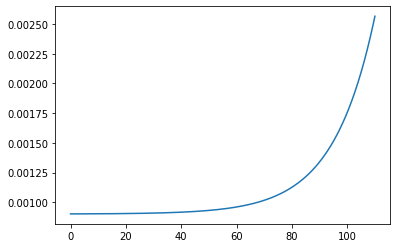

In [2]:
def tau_m(tau0,am,a):
    return tau0*(0.9+25.0*(gamma.pdf(am-a,1.0,scale=15)))

age = np.linspace(0.0,110.0,200)
plt.plot(age,tau_m(0.001,110,age))
print("age 10:",tau_m(0.01,110,10))
print("age 20:",tau_m(0.01,110,20))
print("age 50:",tau_m(0.01,110,50))
print("age 70:",tau_m(0.01,110,70))
print("age 80:",tau_m(0.01,110,80))
print("age 100:",tau_m(0.01,110,100))

For the transmission rate the situation is more complex. We have two phenomena/parameters in this rate:

- the part which depend of the **infectivity of the disease**,
- the part which depend of the **average number of contact by day**.

The second point can be strongly impacted by the age dependency. Here, we can make the assumption than we have more contact with the peoples of the same age.

For more realistic results: *The French Connection: The First Large Population-Based Contact Survey in France Relevant for the Spread of Infectious Diseases, PLOS ONE*.

**Transmission rate**:

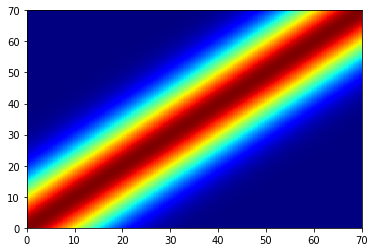

[[0.30938422 0.30936257 0.30929768 ... 0.27       0.27       0.27      ]
 [0.30936257 0.30938422 0.30936257 ... 0.27       0.27       0.27      ]
 [0.30929768 0.30936257 0.30938422 ... 0.27       0.27       0.27      ]
 ...
 [0.27       0.27       0.27       ... 0.30938422 0.30936257 0.30929768]
 [0.27       0.27       0.27       ... 0.30936257 0.30938422 0.30936257]
 [0.27       0.27       0.27       ... 0.30929768 0.30936257 0.30938422]]


In [3]:
def fbeta(beta0,sigma,a1,a2):

    return beta0*(0.90+0.9*np.exp(-((a1-a2)*(a1-a2)-beta0)/(sigma*sigma))/np.sqrt(np.pi*sigma))

age = np.linspace(0.0,70.0,200)
X, Y = np.meshgrid(age, age)
Z =fbeta(0.3,15.0,X,Y)
plt.pcolor(X, Y, Z, cmap='jet')
plt.show()
print(Z)

To finish we must construct the **age distrubution of the population.** It will be useful to construct the initialization of our simulations. **N0 Distribution**:

In [4]:
def N0(a):
    res =0.0
    if a <=10.0:
        res = 0.125/10
    elif a>10.0 and a<=20.0:
        res = 0.115/10
    elif a>20.0 and a<=30.0:
        res = 0.11/10
    elif a>30.0 and a<=40.0:
        res = 0.125/10
    elif a>40.0 and a<=50.0:
        res = 0.13/10
    elif a>50.0 and a<=60.0:
        res = 0.105/10
    elif a>60.0 and a<=70.0:
        res = 0.125/10
    elif a>70.0 and a<=80.0:
        res = 0.085/10
    else:
        res = 0.09/30
    return res

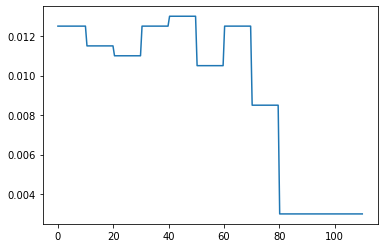

In [5]:
age = np.linspace(0.0,110.0,200)
VN0= np.vectorize(N0)
plt.plot(age,VN0(age))

## Multi-group approximation

In the **radiative transfer theory** we have a transport equation which depend of lot of variable and in particular, the frequency. In general We don't solve the equation for a large set of frequency. We use the multi-group theory where the idea is to integrate the model on different frequency segment.

Here the idea is to construct some group like this:

$$
I_{a_i} =\int_{a_i}^{a_{i+1}}I(t,a) da
$$

The definition is the same for the variables $S_{a_i}$, $E_{a_i}$ and $R_{a_i}$. Now we will integrate the different terms:

$$
\int_{a_i}^{a_{i+1}}\left(\frac{\partial I(t,a)}{\partial t}+ v\frac{\partial I(t,a)}{\partial a}\right) = \frac{\partial I_{a_i}(t)}{\partial t} + v\left( I_{a_{i+1}}(t)-I_{a_i}(t)\right)
$$


In the following we **assume that $v=\epsilon<<1$** and consequently we neglect term homogeneous to $\epsilon$.

Now considering term as:

$$
\int_{a_i}^{a_{i+1}}\gamma(a)I(t,a) da
$$

We approximate the function $\gamma(a)$ by a piecewise function where on each segment $[a_i,a_{i+1}]$ the function take as value the average value $\gamma_{a_i}$. We obtain consequently

$$
\int_{a_i}^{a_{i+1}}\gamma(a)I(t,a) da \approx \gamma_{i}I_{a_i}
$$

At the end we obtain the following **SEIR multi-age model**:

\begin{align}
\frac{d S_{a_i}(t)}{d t} & = -\left(\sum_j^{n_a} \hat{\beta}_{ij} \frac{I_{a_j}(t)}{N_{a_j}(t)}\right)S_{a_i}(t)  - \tau_{i}^m S_{a_i}(t) + \tau_{i}^n N_{a_i}(t) \\
\frac{d E_{a_i}(t)}{d t} & = \left(\sum_j^{n_a} \hat{\beta}_{ij} \frac{I_{a_j}(t)}{N_{a_j}(t)}\right)S_{a_i}(t) - \sigma_{a_i} E_{a_i}(t)  - \tau_{i}^m E_{a_i}(t)  \\
\frac{d I_{a_i}(t)}{d t} & = \sigma_{i} E_{a_i}(t) -  \gamma_{i} I_{a_i}(t)  - \tau_{i}^m E_{a_i}(t)  \\
\frac{d R_{a_i}(t)}{d t} & = \gamma_{i} I_{a_i}(t)  - \tau_{i}^m E_{a_i}(t)  \\
\end{align}

with $n_a$ the number of group, $\mathbf{\gamma}$, $\mathbf{\sigma}$, $\mathbf{\tau}^n$, $\mathbf{\tau}^m$ vectors of size $n_a$ and $\hat{\beta}$ a $\mathcal{M}_{n_a,n_a}$ matrix.

We can construct **multi-group models** for other variable than age.

A classical one is to separate the population in two. The normal people and the **super spreaders** which have a large **transmission rate**.

## Numerical solution

In [6]:
def SEIRage_model(ngp=4,S0=999,E0=1,I0=0,beta0=0.3,gamma0=0.3,sigma=0.3,taum0=0.0,taun=0.0,ft=50):
    S = [ []  for i in range(0,ngp)]
    E = [ []  for i in range(0,ngp)]
    I = [ []  for i in range(0,ngp)]
    R = [ []  for i in range(0,ngp)]
    N = [ []  for i in range(0,ngp)]
    
    Snp = [ 0.0  for i in range(0,ngp)]
    Enp = [ 0.0  for i in range(0,ngp)]
    Inp = [ 0.0  for i in range(0,ngp)]
    Rnp = [ 0.0  for i in range(0,ngp)]
    
    St = [0.0]; Et = [0.0]; It = [0.0]; Rt= [0.0]; Nt= [0.0]
    
    am = 110
    da = float(am)/float(ngp)
    ai = 0.0
    
    for i in range(0,ngp):
        vol, error = inte.quadrature(VN0,ai,ai+da,tol=8.0e-04, rtol=8.0e-04,maxiter=120)
        S[i].append(S0*vol)
        E[i].append(E0*vol)
        I[i].append(I0*vol)
        R[i].append(0.0)
        N[i].append(S[i][-1]+E[i][-1]+I[i][-1]+R[i][-1])
        ai = ai+da
        
        St[-1] = St[-1]+ S[i][-1]
        Et[-1] = Et[-1]+ E[i][-1]
        It[-1] = It[-1]+ I[i][-1]
        Rt[-1] = Rt[-1]+ R[i][-1]
        Nt[-1] = Nt[-1]+ N[i][-1]        

    times =[0.0]
    dt = 0.1
    while times[-1]<ft:
        St.append(0.0); Et.append(0.0); 
        It.append(0.0); Rt.append(0.0); Nt.append(0.0);
        ai = 0.5*da
        for ia in range(0,ngp):
            lambdai = 0.0
            aj =0.5*da
            for ja in range(0,ngp):
                lambdai = lambdai + fbeta(beta0,15,ai,aj)*I[ja][-1]/N[ja][-1]
                aj = aj +da
                
            taum0_copy=taum0
            tm = tau_m(taum0_copy,am,ai)
            Snp[ia] = S[ia][-1] - dt*lambdai*S[ia][-1] -dt*tm*S[ia][-1]+dt*taun*N[ia][-1]
            Enp[ia] = E[ia][-1] + dt*lambdai*S[ia][-1] -dt*sigma*E[ia][-1]-dt*tm*E[ia][-1]               
            Inp[ia] = I[ia][-1] + dt*sigma*E[ia][-1] -dt*gamma0*I[ia][-1]-dt*tm*I[ia][-1]
            Rnp[ia] = R[ia][-1] + dt*gamma0*I[ia][-1]-dt*tm*R[ia][-1]

            S[ia].append(Snp[ia])
            E[ia].append(Enp[ia])               
            I[ia].append(Inp[ia])
            R[ia].append(Rnp[ia])
            N[ia].append(Snp[ia]+Enp[ia]+Inp[ia]+Rnp[ia])
                
            St[-1] = St[-1]+ S[ia][-1]
            Et[-1] = Et[-1]+ E[ia][-1]
            It[-1] = It[-1]+ I[ia][-1]
            Rt[-1] = Rt[-1]+ R[ia][-1]
            Nt[-1] = Nt[-1]+ N[ia][-1] 
            ai = ai+da
        times.append(times[-1]+dt)

    color=cm.rainbow(np.linspace(0,1,ngp))       
    plt.figure(figsize=(10,8))
    ax1 =plt.subplot(221)
    ax1.margins(0.05)
    ax1.plot(times, Nt, 'r--', label="Tot population") 
    ax1.plot(times, Rt, 'g--', label="Tol recovered") 
    ax1.legend()

    ax2 =plt.subplot(222)
    ax2.margins(0,0) 
    un = np.ones(len(times))
    for i in range(0,ngp):
        ax2.plot(times, I[i], c=color[i], label=i)
    ax2.legend()
    
    ax3 = plt.subplot(212)
    ax3.margins(0, 0)  
    ax3.plot(times, St, label='suceptible')
    ax3.plot(times, Et, label='exposed')
    ax3.plot(times, It, label='infected')
    ax3.legend()
                    

In [7]:
S0 = widgets.IntText(value=1000000,description="S0")
E0 = widgets.IntText(value=1,description="E0")
I0 = widgets.IntText(value=0,description="I0")
b1 = widgets.HBox([S0,E0,I0])

beta0 = widgets.FloatSlider(value=0.3,min=0.01,max=1.0,step=0.02,description="beta0")
gamma0 = widgets.FloatSlider(value=0.3,min=0.01,max=1.0,step=0.02,description="gamma0")
sigma = widgets.FloatSlider(value=0.3,min=0.01,max=1.0,step=0.02,description="sigma")
b2 = widgets.HBox([beta0,gamma0,sigma])

taum0 = widgets.FloatText(value=0.0,description="average tau death:")
taun = widgets.FloatText(value=0.0,description="tau birth:")
b3 = widgets.HBox([taum0,taun])

ngp = widgets.IntSlider(value=2,min=2,max=10,step=1,description="Number of group age:")
ft = widgets.IntText(value=200,description="Final time")
b4 = widgets.HBox([ft,ngp])

ui= widgets.VBox([b1,b2,b3,b4])
out = widgets.interactive_output(SEIRage_model, {'ngp':ngp, 'S0': S0, 'E0': E0, 'beta0': beta0, 
                                                    'sigma': sigma,'gamma0': gamma0, 'taum0':taum0,
                                                    'taun':taun, "ft": ft})

## Numerical results for SIR model with age

In [8]:
display(ui,out)

Output()